In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import datetime
warnings.filterwarnings('ignore')

In [14]:
def get_clean_data(df_original):
    weekday_dict = {
        0:'Wd', 1:'Wd', 2:'Wd', 3:'Wd', 4:'Wd', 5:'F', 6:'F' 
    }
    
    df = df_original.copy(deep=True)
    df['date'] =  pd.to_datetime(df['datetime'].apply(lambda x: x[:10]), format='%Y-%m-%d')
    df['year'] = df['date'].dt.year
    df['time'] = pd.to_datetime(df['datetime'].apply(lambda x: x[:19])).dt.time
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['datetime'].apply(lambda x: x[11:13]).astype(int)
    df['minute'] = df['datetime'].apply(lambda x: x[14:16]).astype(int)
    df['weekday'] = df['date'].dt.dayofweek
    df.replace({'weekday':weekday_dict}, inplace=True)
    df['season'] = np.where(df['month'].isin(list(range(4,10))), 'summer', 'winter')
    df['date_hour'] = df.apply(lambda x: datetime.datetime.combine(x['date'], x['time']), axis=1)
    df.set_index('date_hour', inplace=True)
    df = df[df.index < '2017']
    clean_df = df[['date', 'year', 'month', 'season', 'day','weekday','time', 'hour', 'minute', 'value']]
    clean_df = clean_df[~clean_df.index.duplicated()]
    clean_df['hour'] = np.where(clean_df['hour'].isin(np.arange(9,23)), 'Peak', 'off_peak')
    #clean_df['value'] = np.log1p(clean_df['value'])
    clean_df_freq = clean_df.asfreq('H')
    #clean_df_freq['value'] = np.where(clean_df_freq['value'].isnull(), 0, clean_df_freq['value'])
    
    return clean_df_freq

### Price of secondary reserve up

In [15]:
raw_reserve_price = pd.read_csv('2014_2016_training_files/export_PrecioDeRegulaciónSecundariaSubir_2017-03-01_09-01.csv',
                               encoding='latin1', delimiter=';')
reserve_price = get_clean_data(raw_reserve_price).rename(columns={'value':'reserve'})

In [16]:
raw_spot_price = pd.read_csv('2014_2016_training_files/export_PrecioMercadoSPOTDiario_2017-02-02_09-47.csv', encoding='latin1', delimiter=';')
raw_spot_price = raw_spot_price[raw_spot_price['geoid'] == 3]
spot_price = get_clean_data(raw_spot_price)
spot_price = spot_price.rename(columns={'value':'spot'})

In [17]:
raw_demand = pd.read_csv('2014_2016_training_files/export_DemandaProgramada_2017-02-02_09-45.csv', encoding='latin1', delimiter=';')
demand = get_clean_data(raw_demand)
demand = demand.rename(columns={'value':'demand'})

In [18]:
spot_res_demand = reserve_price.merge(spot_price[['spot']], how='left', left_index=True, right_index=True)
spot_res_demand = spot_res_demand.merge(demand[['demand']], how='left', left_index=True, right_index=True)

In [7]:
spot_res_demand = spot_res_demand[['hour', 'weekday', 'season', 'spot','demand', 'reserve']]

In [8]:
for feature in ['hour', 'weekday', 'season']:
    spot_res_demand[pd.get_dummies(spot_res_demand[feature], drop_first=True).columns.tolist()] = pd.get_dummies(spot_res_demand[feature], drop_first=True)

In [9]:
for feature in ['demand', 'spot']:
    spot_res_demand[feature + '-1'] = spot_res_demand[feature].shift(periods=+1)
    spot_res_demand[feature + '-24'] = spot_res_demand[feature].shift(periods=+24)
spot_res_demand['reserve-24'] = spot_res_demand['reserve'].shift(periods=24)
spot_res_demand.dropna(subset=['demand-1', 'spot-1', 'demand-24', 'spot-24', 'reserve-24'], inplace=True)

### Preprocessing for Decision Tree

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import export_graphviz
import graphviz

In [11]:
#Set features and output
X = spot_res_demand.drop(labels=['hour', 'weekday','season', 'reserve'], axis=1).values
Y = spot_res_demand['reserve'].values

In [12]:
spot_res_demand.drop(labels=['hour', 'weekday','season', 'reserve'], axis=1).corr()

,spot,demand,off_peak,Wd,winter,demand-1,demand-24,spot-1,spot-24,reserve-24
spot,1.000000,0.439271,-2.782497e-01,2.362048e-01,-3.455513e-02,0.404751,0.329684,0.966815,0.775220,0.376829
demand,0.439271,1.000000,-6.632193e-01,3.911550e-01,8.202220e-02,0.950713,0.811719,0.418458,0.330222,0.061926
off_peak,-0.278250,-0.663219,1.000000e+00,8.301321e-17,3.785815e-17,-0.630145,-0.662662,-0.259829,-0.277380,-0.003853
Wd,0.236205,0.391155,8.301321e-17,1.000000e+00,-3.754593e-03,0.386605,0.060692,0.234965,0.021821,0.012099
winter,-0.034555,0.082022,3.785815e-17,-3.754593e-03,1.000000e+00,0.081945,0.081045,-0.034386,-0.029929,0.041728
demand-1,0.404751,0.950713,-6.301450e-01,3.866047e-01,8.194535e-02,1.000000,0.772684,0.439311,0.303557,0.062900
demand-24,0.329684,0.811719,-6.626618e-01,6.069245e-02,8.104539e-02,0.772684,1.000000,0.313280,0.440859,0.086790
spot-1,0.966815,0.418458,-2.598290e-01,2.349651e-01,-3.438614e-02,0.439311,0.313280,1.000000,0.761822,0.375872
spot-24,0.775220,0.330222,-2.773799e-01,2.182063e-02,-2.992868e-02,0.303557,0.440859,0.761822,1.000000,0.437240
reserve-24,0.376829,0.061926,-3.852887e-03,1.209888e-02,4.172767e-02,0.062900,0.086790,0.375872,0.437240,1.000000


In [13]:
features_list = spot_res_demand.drop(labels=['hour', 'weekday','season', 'reserve'], axis=1).columns.tolist()

In [14]:
#Split data set into train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, 
                                                    test_size=0.2, random_state=0)

### Randomized Search CV

In [15]:
params = {
    'criterion':['mse'],
    'splitter':['best','random'],
    'max_features':['auto','log2', 'sqrt'],
    'max_depth':np.arange(2,10), 'min_samples_split':np.linspace(50, 1000, 200).astype(int),
    'min_samples_leaf': np.linspace(200, 2500, 50).astype(int), 'max_leaf_nodes': np.linspace(10,180, 40).astype(int)
}

In [16]:
#Random search, set up tree and cross-validation
tree = DecisionTreeRegressor()
kf = KFold(n_splits=5)

#Randomized Search CV for tree
random_search = RandomizedSearchCV(tree, param_distributions=params, n_jobs=-1, n_iter=350,
                                scoring='neg_mean_squared_error', cv=list(kf.split(x_train,y_train)), random_state=0)

In [17]:
%%time
random_search.fit(x_train, y_train);

Wall time: 16.1 s


RandomizedSearchCV(cv=[(array([ 4205,  4206, ..., 21022, 21023]), array([   0,    1, ..., 4203, 4204])), (array([    0,     1, ..., 21022, 21023]), array([4205, 4206, ..., 8408, 8409])), (array([    0,     1, ..., 21022, 21023]), array([ 8410,  8411, ..., 12613, 12614])), (array([    0,     1, ..., 21022, 21023]), array([12615, 12616, ..., 16818, 16819])), (array([    0,     1, ..., 16818, 16819]), array([16820, 16821, ..., 21022, 21023]))],
          error_score='raise',
          estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
          fit_params={}, iid=True, n_iter=350, n_jobs=-1,
          param_distributions={'splitter': ['best', 'random'], 'max_leaf_nodes': array([ 10,  14,  18,  23,  27,  31,  36,  40,  44,  49,  53,  57,  62,
    

In [18]:
best_params = random_search.cv_results_['params'][np.flatnonzero(random_search.cv_results_['rank_test_score']==1)[0]]
print(best_params)

{'splitter': 'best', 'max_leaf_nodes': 140, 'max_features': 'auto', 'min_samples_leaf': 293, 'max_depth': 6, 'min_samples_split': 408, 'criterion': 'mse'}


In [19]:
tree.set_params(**best_params, random_state=0)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features='auto',
           max_leaf_nodes=140, min_impurity_split=1e-07,
           min_samples_leaf=293, min_samples_split=408,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

In [20]:
#CV with kfold=5
kf = KFold(n_splits=5, random_state=0)

CV_mse = list()
CV_mae = list()

for train_index, test_index in kf.split(x_train, y_train):
    tree.fit(x_train[train_index], y_train[train_index])
    y_pred = tree.predict(x_train[test_index])
    CV_mae.append(mean_absolute_error(y_train[test_index], y_pred))
    CV_mse.append(mean_squared_error(y_train[test_index], y_pred))
    
print('Mean absolute error: %0.4f +- %0.4f' %(np.mean(CV_mae), 2*np.std(CV_mae)))
print('Mean squared error: %0.4f +- %0.4f' %(np.mean(CV_mse), 2*np.std(CV_mse)))

Mean absolute error: 12.5237 +- 0.0913
Mean squared error: 336.0224 +- 55.6867


In [21]:
CV_mae, CV_mse

([12.495638764257393,
  12.501391710409536,
  12.568554189073113,
  12.466804731371791,
  12.586098683055601],
 [326.56764051320363,
  317.24033099704116,
  320.7218791207755,
  391.34882721342422,
  324.23348680834965])

In [22]:
tree.fit(x_train, y_train)
print('MAE: ' +str(mean_absolute_error(y_train, tree.predict(x_train)))+', MSE: ' +
      str(mean_squared_error(y_train, tree.predict(x_train))))

MAE: 12.3359899969, MSE: 325.927263754


In [23]:
#Print test error and feature importance
print('MAE: ' +str(mean_absolute_error(y_test, tree.predict(x_test)))+', MSE: ' +
      str(mean_squared_error(y_test, tree.predict(x_test))))
pd.DataFrame(data=tree.feature_importances_, index=features_list)

MAE: 12.1928411523, MSE: 312.553840591


,0
spot,0.716757
demand,0.025510
off_peak,0.000000
Wd,0.000000
winter,0.003762
demand-1,0.003071
demand-24,0.037066
spot-1,0.031052
spot-24,0.004731
reserve-24,0.178050


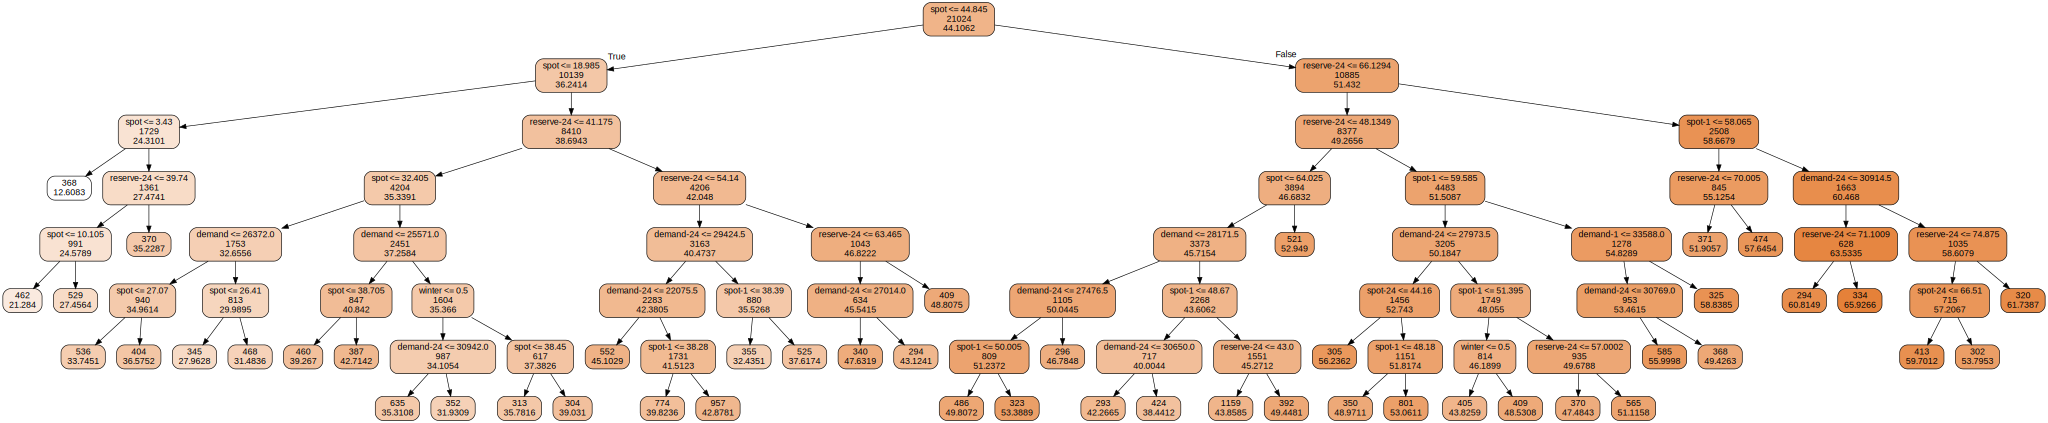

In [24]:
#Plot tree with graphviz
export_graphviz(tree, out_file="mytree.dot", max_depth=None, feature_names=features_list, label='none',
               filled=True, leaves_parallel=False, impurity=False, node_ids=False, proportion=False, rotate=False,
               rounded=True, special_characters=False)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### Random Forest Regressor

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
rfr = RandomForestRegressor()

In [30]:
params_forest = {
    'n_estimators':np.linspace(5, 200, 50).astype(int),
    'n_jobs':[-1],
    'criterion':['mse'], 'bootstrap':[True],
    'max_features':['log2', 'sqrt'],
    'max_depth':np.arange(2,10), 'min_samples_split':np.linspace(50, 1000, 200).astype(int),
    'min_samples_leaf': np.linspace(200, 2500, 50).astype(int), 'max_leaf_nodes': np.linspace(10,180, 40).astype(int)
}

In [31]:
kf = KFold(n_splits=5, random_state=0)

#Randomized Search CV for random forest
random_search = RandomizedSearchCV(rfr, param_distributions=params_forest, n_jobs=-1, n_iter=350,
                                scoring='neg_mean_squared_error', cv=list(kf.split(x_train,y_train)), random_state=0)

In [32]:
%%time
random_search.fit(x_train, y_train);

Wall time: 11min 54s


RandomizedSearchCV(cv=[(array([ 4205,  4206, ..., 21022, 21023]), array([   0,    1, ..., 4203, 4204])), (array([    0,     1, ..., 21022, 21023]), array([4205, 4206, ..., 8408, 8409])), (array([    0,     1, ..., 21022, 21023]), array([ 8410,  8411, ..., 12613, 12614])), (array([    0,     1, ..., 21022, 21023]), array([12615, 12616, ..., 16818, 16819])), (array([    0,     1, ..., 16818, 16819]), array([16820, 16821, ..., 21022, 21023]))],
          error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=350, n_jobs=-1,
          param_distributions={'n_estimators': array([  5,   8,  12,  16,  20,  24,  28

In [33]:
best_params = random_search.cv_results_['params'][np.flatnonzero(random_search.cv_results_['rank_test_score']==1)[0]]
print(best_params)

{'bootstrap': True, 'n_estimators': 80, 'max_leaf_nodes': 136, 'n_jobs': -1, 'min_samples_leaf': 200, 'max_depth': 9, 'min_samples_split': 183, 'criterion': 'mse', 'max_features': 'log2'}


In [34]:
rfr.set_params(**best_params, random_state=0)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='log2', max_leaf_nodes=136,
           min_impurity_split=1e-07, min_samples_leaf=200,
           min_samples_split=183, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [35]:
#CV with kfold=5
kf = KFold(n_splits=5, random_state=0)

CV_mse = list()
CV_mae = list()

for train_index, test_index in kf.split(x_train, y_train):
    rfr.fit(x_train[train_index], y_train[train_index])
    y_pred = rfr.predict(x_train[test_index])
    CV_mae.append(mean_absolute_error(y_train[test_index], y_pred))
    CV_mse.append(mean_squared_error(y_train[test_index], y_pred))
    
print('Mean absolute error: %0.4f +- %0.4f' %(np.mean(CV_mae), 2*np.std(CV_mae)))
print('Mean squared error: %0.4f +- %0.4f' %(np.mean(CV_mse), 2*np.std(CV_mse)))

Mean absolute error: 12.3761 +- 0.1000
Mean squared error: 329.9217 +- 54.7895


In [36]:
CV_mae, CV_mse

([12.370737507284678,
  12.42297648826235,
  12.435135814391513,
  12.296252551775908,
  12.355590482061242],
 [322.6717675151138,
  311.11002803260789,
  314.50549644279965,
  384.18711488501475,
  317.13410139930869])

In [37]:
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='log2', max_leaf_nodes=136,
           min_impurity_split=1e-07, min_samples_leaf=200,
           min_samples_split=183, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [38]:
print('Training MAE: ' +str(mean_absolute_error(y_train, rfr.predict(x_train)))+', Training MSE: ' +
      str(mean_squared_error(y_train, rfr.predict(x_train))))

Training MAE: 12.2136644426, Training MSE: 322.356562324


In [39]:
#Print test error and feature importance
print('MAE: ' +str(mean_absolute_error(y_test, rfr.predict(x_test)))+', MSE: ' +
      str(mean_squared_error(y_test, rfr.predict(x_test))))
pd.DataFrame(data=rfr.feature_importances_, index=features_list)

MAE: 12.0581252338, MSE: 306.585430029


,0
spot,0.305548
demand,0.017494
off_peak,0.012211
Wd,0.002564
winter,0.003737
demand-1,0.020845
demand-24,0.025283
spot-1,0.269372
spot-24,0.121340
reserve-24,0.221605


In [40]:
# Customised random forest, this is the final model
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='log2', max_leaf_nodes=130,
           min_impurity_split=1e-07, min_samples_leaf=250,
           min_samples_split=500, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [41]:
rfr.fit(x_train, y_train)
#CV with kfold=5
kf = KFold(n_splits=5, random_state=0)

CV_mse = list()
CV_mae = list()

for train_index, test_index in kf.split(x_train, y_train):
    rfr.fit(x_train[train_index], y_train[train_index])
    y_pred = rfr.predict(x_train[test_index])
    CV_mae.append(mean_absolute_error(y_train[test_index], y_pred))
    CV_mse.append(mean_squared_error(y_train[test_index], y_pred))
    
print('Mean absolute error: %0.4f +- %0.4f' %(np.mean(CV_mae), 2*np.std(CV_mae)))
print('Mean squared error: %0.4f +- %0.4f' %(np.mean(CV_mse), 2*np.std(CV_mse)))

Mean absolute error: 12.4054 +- 0.1164
Mean squared error: 331.0829 +- 54.5041


In [42]:
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='log2', max_leaf_nodes=130,
           min_impurity_split=1e-07, min_samples_leaf=250,
           min_samples_split=500, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [43]:
print('Training MAE: ' +str(mean_absolute_error(y_train, rfr.predict(x_train)))+', Training MSE: ' +
      str(mean_squared_error(y_train, rfr.predict(x_train))))

Training MAE: 12.2598791404, Training MSE: 324.491079508


In [44]:
print('MAE: ' +str(mean_absolute_error(y_test, rfr.predict(x_test)))+', MSE: ' +
      str(mean_squared_error(y_test, rfr.predict(x_test))))
pd.DataFrame(data=rfr.feature_importances_, index=features_list)

MAE: 12.0763512461, MSE: 307.568616576


,0
spot,0.305957
demand,0.015243
off_peak,0.010892
Wd,0.002264
winter,0.003317
demand-1,0.019297
demand-24,0.023349
spot-1,0.274193
spot-24,0.116955
reserve-24,0.228532


### Gradient Boosting

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

In [46]:
gbr = GradientBoostingRegressor()

In [61]:
params_boosting = {
    'learning_rate': np.linspace(0.01, 0.1, 10).astype(float),
    'n_estimators':np.linspace(10, 200, 50).astype(int),
    'criterion':['mse', 'friedman_mse'],
    'max_features':['log2', 'sqrt', 'auto'],
    'max_depth':np.arange(2,10), 'min_samples_split':np.linspace(50, 1000, 20).astype(int),
    'min_samples_leaf': np.linspace(200, 2500, 50).astype(int), 'max_leaf_nodes': np.linspace(10,180, 40).astype(int)
}

In [62]:
kf= KFold(n_splits=5, random_state=0)

random_search = RandomizedSearchCV(gbr, param_distributions=params_boosting, n_jobs=-1, n_iter=350,
                                scoring='neg_mean_squared_error', cv=list(kf.split(x_train,y_train)), random_state=0)

In [63]:
%%time
random_search.fit(x_train, y_train);

Wall time: 11min 15s


RandomizedSearchCV(cv=[(array([ 4205,  4206, ..., 21022, 21023]), array([   0,    1, ..., 4203, 4204])), (array([    0,     1, ..., 21022, 21023]), array([4205, 4206, ..., 8408, 8409])), (array([    0,     1, ..., 21022, 21023]), array([ 8410,  8411, ..., 12613, 12614])), (array([    0,     1, ..., 21022, 21023]), array([12615, 12616, ..., 16818, 16819])), (array([    0,     1, ..., 16818, 16819]), array([16820, 16821, ..., 21022, 21023]))],
          error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
          fit_params={}, iid=True, n_iter=350, n_jobs=-1,
          param

In [64]:
best_params = random_search.cv_results_['params'][np.flatnonzero(random_search.cv_results_['rank_test_score']==1)[0]]
print(best_params)

{'n_estimators': 110, 'criterion': 'mse', 'max_features': 'sqrt', 'min_samples_leaf': 200, 'max_depth': 7, 'learning_rate': 0.040000000000000008, 'min_samples_split': 350, 'max_leaf_nodes': 101}


In [65]:
gbr.set_params(**best_params, random_state=0)

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.040000000000000008, loss='ls', max_depth=7,
             max_features='sqrt', max_leaf_nodes=101,
             min_impurity_split=1e-07, min_samples_leaf=200,
             min_samples_split=350, min_weight_fraction_leaf=0.0,
             n_estimators=110, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [66]:
#CV with kfold=5
kf = KFold(n_splits=5, random_state=0)

CV_mse = list()
CV_mae = list()

for train_index, test_index in kf.split(x_train, y_train):
    gbr.fit(x_train[train_index], y_train[train_index])
    y_pred = gbr.predict(x_train[test_index])
    CV_mae.append(mean_absolute_error(y_train[test_index], y_pred))
    CV_mse.append(mean_squared_error(y_train[test_index], y_pred))
    
print('Mean absolute error: %0.4f +- %0.4f' %(np.mean(CV_mae), 2*np.std(CV_mae)))
print('Mean squared error: %0.4f +- %0.4f' %(np.mean(CV_mse), 2*np.std(CV_mse)))

Mean absolute error: 12.2004 +- 0.0651
Mean squared error: 323.4099 +- 58.4713


In [67]:
gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.040000000000000008, loss='ls', max_depth=7,
             max_features='sqrt', max_leaf_nodes=101,
             min_impurity_split=1e-07, min_samples_leaf=200,
             min_samples_split=350, min_weight_fraction_leaf=0.0,
             n_estimators=110, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [69]:
print('Training MAE: ' +str(mean_absolute_error(y_train, gbr.predict(x_train)))+', Training MSE: ' +
      str(mean_squared_error(y_train, gbr.predict(x_train))))

Training MAE: 11.7325274555, Training MSE: 300.323927117


In [70]:
print('MAE: ' +str(mean_absolute_error(y_test, gbr.predict(x_test)))+', MSE: ' +
      str(mean_squared_error(y_test, gbr.predict(x_test))))
pd.DataFrame(data=gbr.feature_importances_, index=features_list)

MAE: 11.8695324733, MSE: 299.588861019


,0
spot,0.216250
demand,0.074978
off_peak,0.012095
Wd,0.008047
winter,0.018160
demand-1,0.086925
demand-24,0.089541
spot-1,0.199167
spot-24,0.126100
reserve-24,0.168738


In [122]:
#Customized Gradient Boosting
gbr = GradientBoostingRegressor(n_estimators=1000, criterion='mse', max_features=None,
                               min_samples_leaf=10, max_depth=7, learning_rate=0.02,
                                max_leaf_nodes=100, random_state=0)

In [123]:
kf = KFold(n_splits=5, random_state=0)

CV_mse = list()
CV_mae = list()

for train_index, test_index in kf.split(x_train, y_train):
    gbr.fit(x_train[train_index], y_train[train_index])
    y_pred = gbr.predict(x_train[test_index])
    CV_mae.append(mean_absolute_error(y_train[test_index], y_pred))
    CV_mse.append(mean_squared_error(y_train[test_index], y_pred))
    
print('Mean absolute error: %0.4f +- %0.4f' %(np.mean(CV_mae), 2*np.std(CV_mae)))
print('Mean squared error: %0.4f +- %0.4f' %(np.mean(CV_mse), 2*np.std(CV_mse)))

Mean absolute error: 12.2644 +- 0.1356
Mean squared error: 329.7125 +- 58.4854
